# Research Notebook - M1 SID Mini-Projet

Ce notebook contient toutes les informations concernant la méthodologie utilisée pour le mini-projet de M1 SID, les différentes pistes explorées et les résultats obtenus ainsi que leur commentaires afin de comprendre le fonctionnement de l'application.

## Import des librairies et des données

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [1]:
#importer tous les fichiers csv du dossier transactions-ser avec pandas et les concatener dans un seul fichier pickle

def import_csv():
    import glob
    import os
    import pickle
    path = r'./transactions-ser'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    #pour chaque ligne, ajouter une colonne 'cadastre' avec les 2 derniers caractères du nom du fichier avant .csv
    df_from_each_file = (pd.read_csv(f, sep=';', encoding='latin-1', low_memory=False).assign(cadastre=f[-6:-4]) for f in all_files)

    df = pd.concat(df_from_each_file, ignore_index=True)
    df.to_pickle("transaction_ser.pkl")
    return df
    

## Exploration des données

In [164]:
ds = pd.read_pickle('transaction_ser.pkl')
ds

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe,cadastre
0,2022-360376,2022-05-16,1,Vente,170000.0,6.0,None,PL DE L EGLISE,730,76800,...,4.0,S,sols,None,None,319.0,1.106595,49.382037,000AZ,AZ
1,2022-360376,2022-05-16,1,Vente,170000.0,37.0,None,RUE GAMBETTA,974,76800,...,NaN,S,sols,None,None,234.0,1.106238,49.382039,000AZ,AZ
2,2021-1184802,2021-11-10,1,Vente,107000.0,39.0,None,RUE GAMBETTA,974,76800,...,4.0,S,sols,None,None,38.0,1.106127,49.382122,000AZ,AZ
3,2021-1184802,2021-11-10,1,Vente,107000.0,39.0,None,RUE GAMBETTA,974,76800,...,0.0,S,sols,None,None,38.0,1.106127,49.382122,000AZ,AZ
4,2021-1184802,2021-11-10,1,Vente,107000.0,37.0,None,RUE GAMBETTA,974,76800,...,NaN,S,sols,None,None,234.0,1.106238,49.382039,000AZ,AZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2967,2017-543786,2017-08-28,1,Vente,65000.0,4.0,None,RUE DE FORT DE VAUX,910,76800,...,2.0,S,sols,None,None,268.0,1.107607,49.374767,000AT,AT
2968,2017-543907,2017-08-25,1,Vente,181400.0,19.0,None,RUE DE LORRAINE,1510,76800,...,6.0,S,sols,None,None,401.0,1.100599,49.373885,000AT,AT
2969,2017-543907,2017-08-25,1,Vente,181400.0,19.0,None,RUE DE LORRAINE,1510,76800,...,NaN,J,jardins,POTAG,Jardin potager,89.0,1.100471,49.373929,000AT,AT
2970,2017-543682,2017-08-21,1,Vente,199000.0,29.0,None,CHE DU BON CLOS,300,76800,...,5.0,S,sols,None,None,362.0,1.100397,49.374971,000AT,AT


> Le dataset contient les données de 2972 transactions, ainsi que 42 colonnes. Parmis ces 42 colonnes, la plupart ne nous sont pas utiles (comme le numero de transaction, les adresses et sous-adresse ou encore toutes les données correspondant aux département ou communes puisque nous travaillons ici sur des données toutes issues d'une même ville)

> Une colonne qui nous interresse cependant est la colonne **code_type_local** : celle-ci contient un code faisant référence au type de batiment (appartement, maison, local commercial, etc). Nous allons donc filtrer les données pour ne garder que les appartements et les maisons (cad les codes 1 et 2)

In [223]:
ds = pd.read_pickle('transaction_ser.pkl')
#On supprime les codes type local qui ne sont pas des maisons ou appartements
ds = ds[ds['code_type_local'].isin(['1',1,'2',2])]
ds['code_type_local'] = ds['code_type_local'].astype('int64')

#On ne garde que les features qui peuvent avoir du sens
ds = ds[['date_mutation','valeur_fonciere', 'surface_reelle_bati', 'surface_terrain', 'nombre_pieces_principales', 'cadastre','latitude','longitude','code_type_local']]

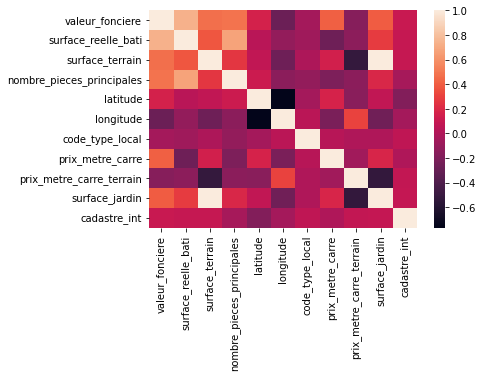

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

#supprimer les lignes avec valeur foncière > 2 000 000
ds = ds[ds['valeur_fonciere'] <= 500000]
ds = ds[ds['valeur_fonciere'] >= 5000]
#supprimer les lignes avec surface terrain > 25000
ds = ds[ds['surface_terrain'] < 25000]

# #supprimer les lignes avec surface bati > 1000
ds = ds[ds['surface_reelle_bati'] < 1000]

# #supprimer les lignes avec nombre de pièces > 10
ds = ds[ds['nombre_pieces_principales'] < 10]
ds = ds[ds['nombre_pieces_principales'] != 0]

ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']
ds['prix_metre_carre_terrain'] = ds['valeur_fonciere'] / ds['surface_terrain']

#ajouter une colonne pour la taille du jardin en m²
ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']

#a chaque cadastre on associe un code en int
ds['cadastre_int'] = ds['cadastre'].astype('category')
ds['cadastre_int'] = ds['cadastre_int'].cat.codes




#supprimer les valeurs trop hautes :
ds = ds[ds['prix_metre_carre'] < 3500]
ds = ds[ds['prix_metre_carre'] > 1000]

#afficher la matrice de corrélation
corr = ds.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

> On remarque que les variables qui semblent avoir de l'influence sur le prix sont : la surface du bien, la surface du terrain, le nombre de pièces, la surface du jardin ainsi que la latitude.

> Evidemment, la surface de jardin est directement dérivée de la surface du terrain, cependant elle a plus de valeur car elle permet d'éviter d'avoir des None si on a pas de jardin ou d'avoir une surface terrain égale à celle du bati. Ici on a exactement la taille du jardin.

>Enfin, la latitude et la longitude représentent sans doute des données trop précices et sont surtout impossible à demander à l'utilisateur. Utiliser le code du cadastre mais en effectuant des moyennes des prix au m² pour chaque code cadastre serait une solution plus réaliste.

> Enfin les dates ne sont pas prix en compte car seaborn ne supporte pas les string. De plus étudier la date exacte de vente ne permettrait certainement pas de trouver une corélation avec le prix, c'est trop variable. On va voir si on notre intuition concernant une possible inflation visible en moyennant par mois se vérifie :

## Inflation au fil des mois

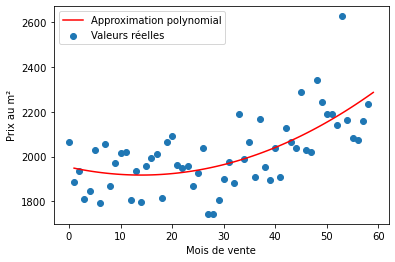

In [225]:

#regrouper par mois et calculer la moyenne du prix au m²
ds = ds[['date_mutation', 'prix_metre_carre', 'prix_metre_carre_terrain']]

# # #supprimer les valeurs trop hautes :
# # ds = ds[ds['prix_metre_carre'] < 5000]
# # ds = ds[ds['prix_metre_carre'] > 1000]


#groupby month :
ds['date_mutation'] = pd.to_datetime(ds['date_mutation'])
ds['date_mutation'] = ds['date_mutation'].dt.to_period('M')

ds = ds.groupby(['date_mutation']).mean()
ds = ds.reset_index()


#date mutation en string
ds['date_mutation'] = ds['date_mutation'].astype(str)
#afficher avec plotly
import plotly.express as px
fig = px.line(ds, x='date_mutation', y='prix_metre_carre', title='Evolution des prix au m² en fonction du temps dans la ville de Saint-Etienne-Du-Rouvray')
#ajouter la légende des 2 axes
fig.update_xaxes(title_text='Date de vente')
fig.update_yaxes(title_text='Prix au m²')
fig.show()

#on crée une nouvelle colonne avec des ints allant de 1 à len(ds)
ds['date_mutation_int'] = range(0, len(ds))

#obtenir une approximation polynomiale de degré 3 de la fonction avec 'date_mutation_int' en x et 'prix_metre_carre' en y
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(ds['date_mutation_int'].values.reshape(-1, 1), ds['prix_metre_carre'].values.reshape(-1, 1))

#afficher l'approximation polynomiale
import matplotlib.pyplot as plt
import numpy as np

x_plot = np.linspace(1, len(ds), 100)
plt.scatter(ds['date_mutation_int'], ds['prix_metre_carre'])
plt.plot(x_plot, model.predict(x_plot[:, np.newaxis]), color='red')
#ajouter la légende des 2 axes
plt.xlabel('Mois de vente')
plt.ylabel('Prix au m²')
#légende
plt.legend(['Approximation polynomial', 'Valeurs réelles'])
plt.show()

> Notre intuition était bonne ! les prix ont bien augmenté au fil des mois. On peut donc supposer que les prix sont corrélés à la date de vente et on va pouvoir utiliser cette feature pour notre modèle. Attention cependant, il faudra bien penser à utiliser uniquement le mois de vente, car les données ont une variance beaucoup trop forte au jour le jour.

## Différence de prix au m² en fonction des cadastres

In [228]:
ds = pd.read_pickle('transaction_ser.pkl')
#On supprime les codes type local qui ne sont pas des maisons ou appartements
ds = ds[ds['code_type_local'].isin(['1',1,'2',2])]
ds['code_type_local'] = ds['code_type_local'].astype('int64')

#On ne garde que les features qui peuvent avoir du sens
ds = ds[['date_mutation','valeur_fonciere', 'surface_reelle_bati', 'surface_terrain', 'nombre_pieces_principales', 'cadastre','latitude','longitude','code_type_local']]


#supprimer les lignes avec valeur foncière > 2 000 000
ds = ds[ds['valeur_fonciere'] <= 500000]
ds = ds[ds['valeur_fonciere'] >= 5000]
#supprimer les lignes avec surface terrain > 25000
ds = ds[ds['surface_terrain'] < 25000]

#supprimer les lignes avec surface bati > 1000
ds = ds[ds['surface_reelle_bati'] < 1000]

#supprimer les lignes avec nombre de pièces > 10
ds = ds[ds['nombre_pieces_principales'] < 10]
ds = ds[ds['nombre_pieces_principales'] != 0]

ds = ds.dropna()

ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']
ds['prix_metre_carre_terrain'] = ds['valeur_fonciere'] / ds['surface_terrain']

#regrouper par mois et calculer la moyenne du prix au m²
ds = ds[['cadastre', 'prix_metre_carre', 'prix_metre_carre_terrain']]
#supprimer les valeurs trop hautes :
ds = ds[ds['prix_metre_carre'] < 3500]

ds = ds.groupby(['cadastre']).mean()
ds = ds.reset_index()


In [229]:
#afficher le prix moyen au m² dans les cadastres
import plotly.express as px
fig = px.scatter(ds, x='cadastre', y='prix_metre_carre', title='Prix au m²')
#ajouter une ligne pour la moyenne totale
fig.add_hline(y=ds['prix_metre_carre'].mean())
fig.show()

> Comme on s'en doutait car les différents quartiers d'une ville ont toujours des prix variables en fonction de leur attractivité, les différentes sections cadastrales de saint-etienne-du-rouvray proposen des prix au m² différents. On peut donc supposer que cette feature sera utile pour notre modèle.

## Régression

### Appartements

In [235]:
ds = pd.read_pickle('transaction_ser.pkl')
ds.drop(columns=['numero_disposition','nature_mutation','adresse_numero','adresse_suffixe','adresse_nom_voie','adresse_code_voie','code_postal','nature_culture','code_nature_culture_speciale','nature_culture_speciale','code_commune','nom_commune','code_departement','ancien_code_commune','ancien_nom_commune','id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero','lot4_surface_carrez','lot5_surface_carrez','section_prefixe'], inplace=True)
ds.code_type_local = ds.code_type_local.astype(str)
ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']
ds = ds[ds['code_type_local'].isin(['2'])]
ds = ds[['valeur_fonciere', 'surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre']]
ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']

#plotly matrixtu eu
import plotly.express as px
ds =  ds[ds['prix_metre_carre'] < 4000]
fig = px.scatter_matrix(ds)
fig.update_traces(diagonal_visible=False)
fig.update_layout(height=1000, width=1000)
fig.show()

> Les données des appartements sont peu nombreuses et surtout peu linéaires, mais il semble quand même possible de faire une regression.

#### Régression linéaire :

Score de regression r² :
0.20027209933477974


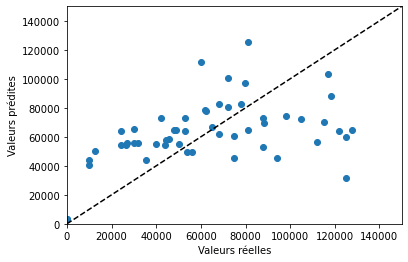

In [239]:
#approximation polynomiale sur toutes les données 
ds = pd.read_pickle('transaction_ser.pkl')
ds.drop(columns=['numero_disposition','nature_mutation','adresse_numero','adresse_suffixe','adresse_nom_voie','adresse_code_voie','code_postal','nature_culture','code_nature_culture_speciale','nature_culture_speciale','code_commune','nom_commune','code_departement','ancien_code_commune','ancien_nom_commune','id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero','lot4_surface_carrez','lot5_surface_carrez','section_prefixe'], inplace=True)
ds = ds[ds['code_type_local'] != 'None']
ds.code_type_local = ds.code_type_local.astype(int)

ds = ds[ds.code_type_local == 2]

ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']
ds = ds[['date_mutation','valeur_fonciere', 'surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local']]
ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']
#drop les lignes ou code_type_local == none
ds = ds[ds['prix_metre_carre'] < 4000]
#pour date_mutation on garde que l'année et le mois
ds['date_mutation'] = ds['date_mutation'].astype(str)
ds['date_mutation'] = ds['date_mutation'].str[:7]
#on utilise mdate pour convertir les dates en int
import matplotlib.dates as mdates
ds['date_mutation'] = pd.to_datetime(ds['date_mutation'])
ds['date_mutation'] = mdates.date2num(ds['date_mutation'])
#à chaque cadastre on associe un code en int
ds['cadastre'] = ds['cadastre'].astype(str)
ds['cadastre'] = ds['cadastre'].str[:14]
ds['cadastre'] = ds['cadastre'].astype('category')
ds['cadastre'] = ds['cadastre'].cat.codes
#fillna avec les moyennes des colonnes
ds['surface_reelle_bati'] = ds['surface_reelle_bati'].fillna(ds['surface_reelle_bati'].mean())
ds['surface_jardin'] = ds['surface_jardin'].fillna(0)






#on effectue une regression polynomiale de 2eme degré sur les données avec en Y 'valeur_foncière' 
#et en X 'date_mutation','surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local'
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(1), LinearRegression())

X = ds[['surface_reelle_bati','surface_jardin','date_mutation','cadastre','nombre_pieces_principales']]
y = ds['valeur_fonciere']

#on split les données en 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

#afficher les coefficients
#print(model.steps[1][1].coef_)
#print(model.steps[1][1].intercept_)

#get_feature_names
#afficher le score
print('Score de regression r² :')
print(model.score(X_test, y_test))
#afficher score r2
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

#mettre les coefs et les noms des features dans un dataframe
coefs = pd.DataFrame(model.steps[1][1].coef_, model.steps[0][1].get_feature_names(['s_bati','s_jardin','date_m','cad','nb_pieces']), columns=['coefs'])
#renommer la 1ere ligne 'intercept'
coefs.rename(index={'1': 'intercept'}, inplace=True)
#remplacer la valeur par l'intercept
coefs['coefs'][0] = model.steps[1][1].intercept_

#afficher les valeurs prédites vs les valeurs réelles
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
#ajouter une ligne de regression
plt.plot([0, 150000], [0, 150000], '--k')
plt.axis('tight')
plt.xlim([0, 150000])
plt.ylim([0, 150000])
plt.show()





> Avec une regression linéaire, on obtient un R² = 0.2, ce qui est très faible. On peut donc supposer que la regression linéaire ne sera pas très utile pour prédire le prix des appartements avec efficacité.

> Notre modèle sous-estime les appartements chers et sur-estime les appartements moins chers. Au final il a une plage de prédiction réduite.

> Etant donné qu'on a vu précemment que la date de vente semblait avoir une influence sur le prix mais que celle-ci n'était pas linéaire, on va essayer de faire une regression polynomiale :

#### Regression polynomiale :

Score de regression r² :
0.48428419136186573


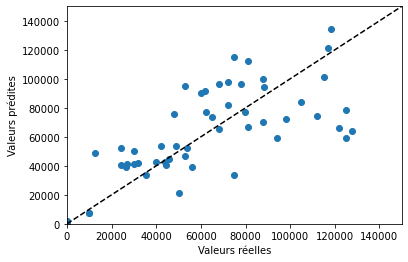

In [238]:
#approximation polynomiale sur toutes les données 
ds = pd.read_pickle('transaction_ser.pkl')
ds.drop(columns=['numero_disposition','nature_mutation','adresse_numero','adresse_suffixe','adresse_nom_voie','adresse_code_voie','code_postal','nature_culture','code_nature_culture_speciale','nature_culture_speciale','code_commune','nom_commune','code_departement','ancien_code_commune','ancien_nom_commune','id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero','lot4_surface_carrez','lot5_surface_carrez','section_prefixe'], inplace=True)
ds = ds[ds['code_type_local'] != 'None']
ds.code_type_local = ds.code_type_local.astype(int)

ds = ds[ds.code_type_local == 2]

ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']
ds = ds[['date_mutation','valeur_fonciere', 'surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local']]
ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']
#drop les lignes ou code_type_local == none
ds = ds[ds['prix_metre_carre'] < 4000]
#pour date_mutation on garde que l'année et le mois
ds['date_mutation'] = ds['date_mutation'].astype(str)
ds['date_mutation'] = ds['date_mutation'].str[:7]
#on utilise mdate pour convertir les dates en int
import matplotlib.dates as mdates
ds['date_mutation'] = pd.to_datetime(ds['date_mutation'])
ds['date_mutation'] = mdates.date2num(ds['date_mutation'])
#à chaque cadastre on associe un code en int
ds['cadastre'] = ds['cadastre'].astype(str)
ds['cadastre'] = ds['cadastre'].str[:14]
ds['cadastre'] = ds['cadastre'].astype('category')
ds['cadastre'] = ds['cadastre'].cat.codes
#fillna avec les moyennes des colonnes
ds['surface_reelle_bati'] = ds['surface_reelle_bati'].fillna(ds['surface_reelle_bati'].mean())
ds['surface_jardin'] = ds['surface_jardin'].fillna(0)






#on effectue une regression polynomiale de 2eme degré sur les données avec en Y 'valeur_foncière' 
#et en X 'date_mutation','surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local'
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(2), LinearRegression())

X = ds[['surface_reelle_bati','surface_jardin','date_mutation','cadastre','nombre_pieces_principales']]
y = ds['valeur_fonciere']

#on split les données en 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

#afficher les coefficients
#print(model.steps[1][1].coef_)
#print(model.steps[1][1].intercept_)

#get_feature_names
#afficher le score
print('Score de regression r² :')
print(model.score(X_test, y_test))
#afficher score r2
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

#mettre les coefs et les noms des features dans un dataframe
coefs = pd.DataFrame(model.steps[1][1].coef_, model.steps[0][1].get_feature_names(['s_bati','s_jardin','date_m','cad','nb_pieces']), columns=['coefs'])
#renommer la 1ere ligne 'intercept'
coefs.rename(index={'1': 'intercept'}, inplace=True)
#remplacer la valeur par l'intercept
coefs['coefs'][0] = model.steps[1][1].intercept_

#afficher les valeurs prédites vs les valeurs réelles
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
#ajouter une ligne de regression
plt.plot([0, 150000], [0, 150000], '--k')
plt.axis('tight')
plt.xlim([0, 150000])
plt.ylim([0, 150000])
plt.show()

> Avec une regression polynomiale de degré 2, on obtient un R² = 0.48, ce qui est déjà beaucoup mieux. Ce n'est pas excellent mais notre observation concernant des données non linéaires mais corrélables était bonne, et on peut maintenant prédire le prix des appartements avec une certaine efficacité.

### Maisons

In [240]:
ds = pd.read_pickle('transaction_ser.pkl')
ds.drop(columns=['numero_disposition','nature_mutation','adresse_numero','adresse_suffixe','adresse_nom_voie','adresse_code_voie','code_postal','nature_culture','code_nature_culture_speciale','nature_culture_speciale','code_commune','nom_commune','code_departement','ancien_code_commune','ancien_nom_commune','id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero','lot4_surface_carrez','lot5_surface_carrez','section_prefixe'], inplace=True)
ds.code_type_local = ds.code_type_local.astype(str)
ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']
ds = ds[ds['code_type_local'].isin(['1'])]
ds = ds[['valeur_fonciere', 'surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre']]
ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']

#plotly matrixtu eu
import plotly.express as px
ds =  ds[ds['prix_metre_carre'] < 4000]
fig = px.scatter_matrix(ds)
fig.update_traces(diagonal_visible=False)
fig.update_layout(height=1000, width=1000)
fig.show()

> Les données des maisons sont beaucoup plus nombreuses et surtout beaucoup plus linéaires, ce qui est très bon signe pour la regression.

> On remarque aussi que la corrélation entre la surface en m² et le nombre de pièce semble très forte. Le nombre de piece ne sera donc pas très utile pour notre modèle car redondant.

Score de regression r² :
0.5232044337789126


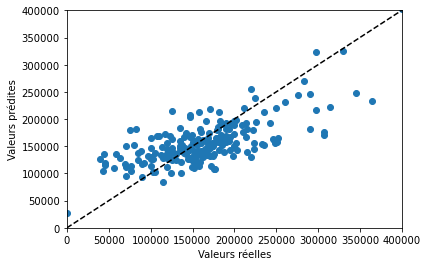

In [244]:
#approximation polynomiale sur toutes les données 
ds = pd.read_pickle('transaction_ser.pkl')
ds.drop(columns=['numero_disposition','nature_mutation','adresse_numero','adresse_suffixe','adresse_nom_voie','adresse_code_voie','code_postal','nature_culture','code_nature_culture_speciale','nature_culture_speciale','code_commune','nom_commune','code_departement','ancien_code_commune','ancien_nom_commune','id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero','lot4_surface_carrez','lot5_surface_carrez','section_prefixe'], inplace=True)
ds = ds[ds['code_type_local'] != 'None']
ds.code_type_local = ds.code_type_local.astype(int)

ds = ds[ds.code_type_local == 1]

ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']
ds = ds[['date_mutation','valeur_fonciere', 'surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local']]
ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']
#drop les lignes ou code_type_local == none
ds = ds[ds['prix_metre_carre'] < 4000]
#pour date_mutation on garde que l'année et le mois
ds['date_mutation'] = ds['date_mutation'].astype(str)
ds['date_mutation'] = ds['date_mutation'].str[:7]
#on utilise mdate pour convertir les dates en int
import matplotlib.dates as mdates
ds['date_mutation'] = pd.to_datetime(ds['date_mutation'])
ds['date_mutation'] = mdates.date2num(ds['date_mutation'])
#à chaque cadastre on associe un code en int
ds['cadastre'] = ds['cadastre'].astype(str)
ds['cadastre'] = ds['cadastre'].str[:14]
ds['cadastre'] = ds['cadastre'].astype('category')
ds['cadastre'] = ds['cadastre'].cat.codes
#fillna avec les moyennes des colonnes
ds['surface_reelle_bati'] = ds['surface_reelle_bati'].fillna(ds['surface_reelle_bati'].mean())
ds['surface_jardin'] = ds['surface_jardin'].fillna(0)

#on effectue une regression polynomiale de 2eme degré sur les données avec en Y 'valeur_foncière' 
#et en X 'date_mutation','surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local'
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(1), LinearRegression())

X = ds[['surface_reelle_bati','surface_jardin','date_mutation','cadastre','nombre_pieces_principales']]
y = ds['valeur_fonciere']

#on split les données en 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

#afficher les coefficients
#print(model.steps[1][1].coef_)
#print(model.steps[1][1].intercept_)

#get_feature_names
#afficher le score
print('Score de regression r² :')
print(model.score(X_test, y_test))
#afficher score r2
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

#mettre les coefs et les noms des features dans un dataframe
coefs = pd.DataFrame(model.steps[1][1].coef_, model.steps[0][1].get_feature_names(['s_bati','s_jardin','date_m','cad','nb_pieces']), columns=['coefs'])
#renommer la 1ere ligne 'intercept'
coefs.rename(index={'1': 'intercept'}, inplace=True)
#remplacer la valeur par l'intercept
coefs['coefs'][0] = model.steps[1][1].intercept_

#afficher les valeurs prédites vs les valeurs réelles
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
#ajouter une ligne de regression
plt.plot([0, 400000], [0, 400000], '--k')
plt.axis('tight')
plt.xlim([0, 400000])
plt.ylim([0, 400000])
plt.show()





> Même observation que pour les appartement, on sur-estime les maisons moins chères et sous-estime les maisons plus chères. Cependant ici on voit qu'on a quand même un R² = 0.52 même avec une regression linéaire, ce qui est beaucoup mieux.

#### Regression polynomiale :

Score de regression r² :
0.6271520983516556


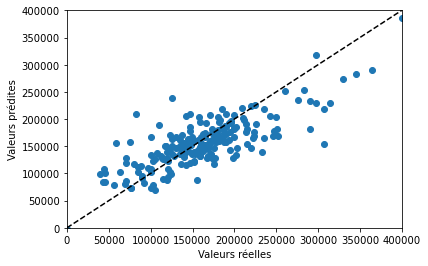

In [249]:
#approximation polynomiale sur toutes les données 
ds = pd.read_pickle('transaction_ser.pkl')
ds.drop(columns=['numero_disposition','nature_mutation','adresse_numero','adresse_suffixe','adresse_nom_voie','adresse_code_voie','code_postal','nature_culture','code_nature_culture_speciale','nature_culture_speciale','code_commune','nom_commune','code_departement','ancien_code_commune','ancien_nom_commune','id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero','lot4_surface_carrez','lot5_surface_carrez','section_prefixe'], inplace=True)
ds = ds[ds['code_type_local'] != 'None']
ds.code_type_local = ds.code_type_local.astype(int)

ds = ds[ds.code_type_local == 1]

ds['surface_jardin'] = ds['surface_terrain'] - ds['surface_reelle_bati']
ds = ds[['date_mutation','valeur_fonciere', 'surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local']]
ds['prix_metre_carre'] = ds['valeur_fonciere'] / ds['surface_reelle_bati']
#drop les lignes ou code_type_local == none
ds = ds[ds['prix_metre_carre'] < 4000]
#pour date_mutation on garde que l'année et le mois
ds['date_mutation'] = ds['date_mutation'].astype(str)
ds['date_mutation'] = ds['date_mutation'].str[:7]
#on utilise mdate pour convertir les dates en int
import matplotlib.dates as mdates
ds['date_mutation'] = pd.to_datetime(ds['date_mutation'])
ds['date_mutation'] = mdates.date2num(ds['date_mutation'])
#à chaque cadastre on associe un code en int
ds['cadastre'] = ds['cadastre'].astype(str)
ds['cadastre'] = ds['cadastre'].str[:14]
ds['cadastre'] = ds['cadastre'].astype('category')
ds['cadastre'] = ds['cadastre'].cat.codes
#fillna avec les moyennes des colonnes
ds['surface_reelle_bati'] = ds['surface_reelle_bati'].fillna(ds['surface_reelle_bati'].mean())
ds['surface_jardin'] = ds['surface_jardin'].fillna(0)

#on effectue une regression polynomiale de 2eme degré sur les données avec en Y 'valeur_foncière' 
#et en X 'date_mutation','surface_reelle_bati','nombre_pieces_principales', 'surface_jardin','cadastre','latitude','longitude','code_type_local'
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(2), LinearRegression())

X = ds[['surface_reelle_bati','surface_jardin','date_mutation','cadastre']]
y = ds['valeur_fonciere']

#on split les données en 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

#afficher les coefficients
#print(model.steps[1][1].coef_)
#print(model.steps[1][1].intercept_)

#get_feature_names
#afficher le score
print('Score de regression r² :')
print(model.score(X_test, y_test))
#afficher score r2
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

#mettre les coefs et les noms des features dans un dataframe
coefs = pd.DataFrame(model.steps[1][1].coef_, model.steps[0][1].get_feature_names(['s_bati','s_jardin','date_m','cad']), columns=['coefs'])
#renommer la 1ere ligne 'intercept'
coefs.rename(index={'1': 'intercept'}, inplace=True)
#remplacer la valeur par l'intercept
coefs['coefs'][0] = model.steps[1][1].intercept_

#afficher les valeurs prédites vs les valeurs réelles
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
#ajouter une ligne de regression
plt.plot([0, 400000], [0, 400000], '--k')
plt.axis('tight')
plt.xlim([0, 400000])
plt.ylim([0, 400000])
plt.show()

> Avec une regression polynomiale, nos données collent encore une fois mieux et on atteint R² = 0.62, ce qui est bon.

## Export des résultats de la regression

> Maintenant que notre regression est effectué, il ne nous reste plus qu'à exporter les coefficients pour pouvoir les réimporter dans l'application à l'aide de fichiers pkl.

In [102]:
coefs_maison = coefs.copy()
coefs_appart = coefs.copy()
#stockers les coefs dans un fichier pickle
coefs_maison.to_pickle('coefs_maison.pkl')
coefs_appart.to_pickle('coefs_appart.pkl')

> Il ne faut pas non plus oublier de crer une matrice d'association des codes cadastres en lettres, et leur équivalent codé en int qui sert dans la regression. Encore une fois, cela permettra d'associer dans l'application la section cadastrale entrée par l'utilisateur avec un code unique utilisé en interne par la prédiction :

In [252]:
ds = pd.read_pickle('transaction_ser.pkl')
ds['cadastre_int'] = ds['cadastre'].astype(str).str[:14].astype('category').cat.codes
ds = ds[['cadastre','cadastre_int']]
ds.drop_duplicates(inplace=True)
ds.to_pickle('cadastre_codes.pkl')